In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as img
import netCDF4 as nc
import numpy as np,cv2
import math
from scipy import signal, interpolate
import skimage
import scipy.misc
import skimage.feature
import skimage.viewer
import sys
import cv2
from scipy.spatial import distance as dist
from skimage.viewer import ImageViewer
from scipy.io import loadmat, savemat 

# CODE TO GET RIPPLE MIGRATION

# 1. Create a time stacked image.. with vertical axis as distance and horizontal axis of time - currently done manually 

# 2. Find edges->Pass the data array to a Python scikit-image Canny Edge Detection function

# 3. Use the OpenCV findContours() algorithm to find the contour of the edges

# 4. Pick a point visually very close to the contour that tracks the ripple movement 

# 5. Find the distance of the point from the contour that we are interested in tracking, the code
# should identify the contour line (if not go to step 3 and change sigma value to change the image's strength to remove 
# small scale features if required)

# Important software requirement 
#  Need an older version of opencv package for things to work here: 
# 3.4.2 - > can be installed via pip install opencv-python==3.4.2
 
# Useful weblinks
#https://rmendels.github.io/canny_doc.html
#https://datacarpentry.org/image-processing/08-edge-detection/
#https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_numpy_array.html
#http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm


C:\Users\tkalra\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
print(cv2.__version__)

3.4.2


In [3]:
# 1. Read a time stacked image.. with vertical axis as distance and horizontal axis of time - currently done manually 

matstack = loadmat('timestacks\stack_MI_subset_4.mat')
dnn = matstack['dnn']
xx  = matstack['xx']
Sv  = matstack['Sv_subset']

401


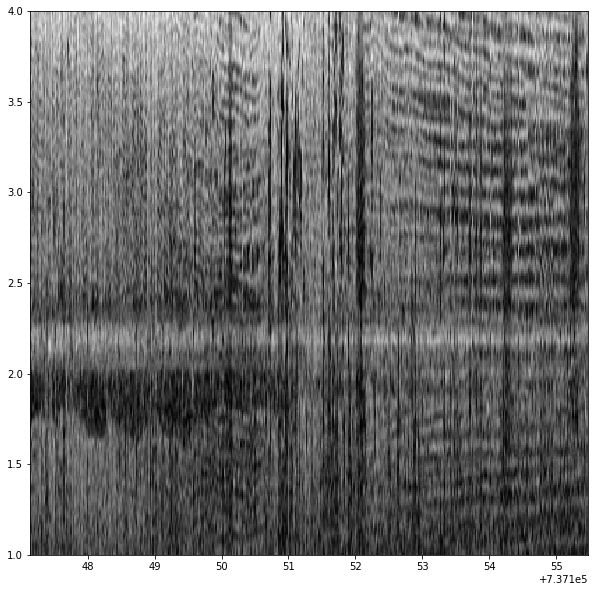

In [4]:
# display time stacked image
dnn=np.squeeze(dnn)
xx=np.squeeze(xx)
len_time=len(dnn)    
print(len_time)
plt.figure(figsize=[10, 10])
plt.pcolor(dnn, xx, Sv, cmap='gray') 

In [5]:
# modify the time axis to whole number values, (1,2,3,4 ) for easier analysis
dnn1=np.linspace(1, len_time, len_time)


In [6]:
#2. setup the parameters for scikit package for edge detection
sigma =6.0 # so far only experimented with sigma-> higher the sigma lesser the small scale features 
low_threshold = 0.8
high_threshold = 0.9

In [7]:
# apply canny edge algorithm 
edges = skimage.feature.canny(
    image=Sv,
    sigma=sigma,
    low_threshold=low_threshold,
    high_threshold=high_threshold,
)

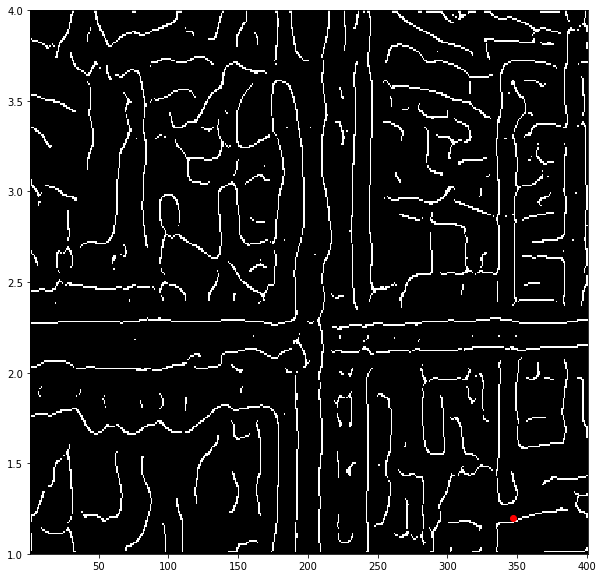

In [8]:
# Step 3. Use the OpenCV findContours() algorithm to find the contour of the edges
edge_image = edges.astype(np.uint8)
Sv_im2, contours, hierarchy = cv2.findContours(edge_image ,cv2.RETR_TREE, 
                                            cv2.CHAIN_APPROX_NONE)

# plot the contours and you should see the ripple movement  
# also pick a point that is the closest to the contour that we want to track in time
t1=347 # for time axis
x1=1.2  # for vertical distance axis 


plt.figure(figsize=[10, 10])
plt.pcolor(dnn1, xx, Sv_im2, cmap='gray')
plt.plot(t1, x1, 'ro')
plt.show()
#plt.savefig('sample_1.png') 

In [9]:
# find the index of the point that we consider the starting point for tracking ripple migration 
# for time axis it is the same number because we convertted time into linspace
# find for x axis 

# plot the contours and you should see the ripple movement  
# also pick a point that is the closest to the contour that we want to track in time

dist= [0] * len(xx)  

#print(class(xx))
for i in range(0, len(xx)):
    dist[i] = abs(xx[i]-x1)

# find the minimum value and its index from a list of values 
val, idx = min((val, idx) for (idx, val) in enumerate(dist))
#print(val)
#print(idx)
#print(x1)
# save the index of point x1 
idx_x1=idx 

In [10]:
# declare the vector that corresponds to the number of countours 
num_contours  = len(contours)
dist_abs = [0] * num_contours  
print(x1)
print(t1)
for i in range(0, num_contours):
    cnt=contours[i]
    # find the distance of the chosen point from all the contours
    dist= cv2.pointPolygonTest(cnt,(t1,idx_x1),True)
    dist_abs[i]=abs(dist)

# find the minimum value and its index from a list of values 
val, idx = min((val, idx) for (idx, val) in enumerate(dist_abs))
# find the value and index of the point and the countour 
print(val)
print(idx)

1.2
347
2.0
286


In [11]:
# Now we know the contour that is closest to the t1, x1 point , find the i and j on that contour line 
#idx=120
#idx=55
contour = contours[idx]
contour_lens = []
contour_len = contour.shape[0]
contour_lens.append(contour_len)
print(contour_len)

jj = [0] * contour_len
ii = [0] * contour_len 

for ilen in list(range(0, contour_len)):
    jj[ilen]=contour[ilen,0,1]
    ii[ilen]=contour[ilen,0,0]
    

131


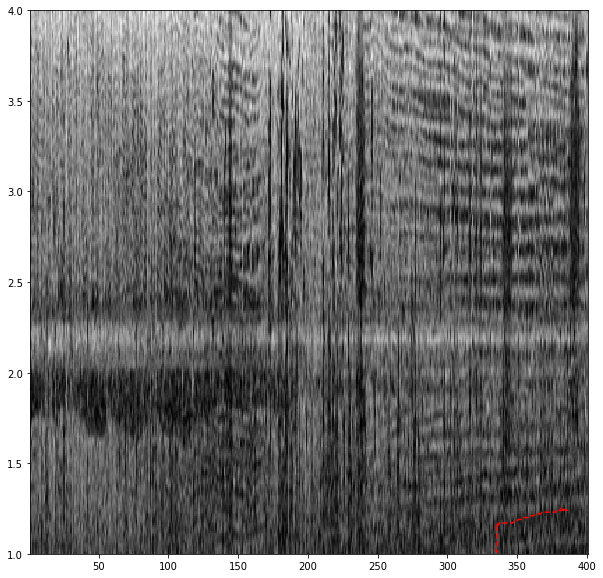

In [12]:
#print(contour_len)
#print(ilen)
itime1=0
itime2=ilen

#to sort the two indices together, sort it based on the position and then the time array will follow suit 
list1=zip(jj,ii)
list2=sorted(set(list1))
 
jj_ss=[i[0] for i in list2]# corresonds to vertical axis
tt_ss=[i[1] for i in list2]# corresponds to time axis 

plt.figure(figsize=[10, 10])
plt.pcolor(dnn1, xx, Sv, cmap='gray') 
itime=ilen

#ii_pick=ii[0:itime]
#jj_pick=jj[0:itime]
jj_pick=jj_ss
tt_pick=tt_ss
#print(ii_ss)

plt.plot(dnn1[tt_pick],xx[jj_pick],'r--')

In [15]:


jj_save = np.array(jj_pick[0:ilen]) 
tt_save = np.array(tt_pick[0:ilen])

# collect arrays in dictionary
savedict = {'tt_save' : tt_pick, 'jj_save' :jj_pick}
# save to disk
savemat('migrate41.mat', savedict)
#scipy.io.savemat('test.mat','a')
#print(xx[2])
#print(dnn[2])